In [27]:

from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd

import pandas as pd 

from tqdm import tqdm
import math


from scipy.stats import norm
from scipy.stats import multivariate_normal

In [28]:
class HMC():
    def __init__(self,mean,cov):

        self.mean = mean
        self.cov = cov
        
        self._inv = np.linalg.inv(cov)
        self._det = np.linalg.det(cov)
        
    def _momentum(self, p):
        """
        運動エネルギーは 正規乱数のlog(= -0.5 * p**2)にマイナスをくっつけたもの
        """
        return 0.5 * np.sum(p**2)

    def _hamiltonian(self,x,p):
        return self._h(x) + self._momentum(p)
    
    def _multi_gauss(self,x):
        # こいつで一致1/(2*math.pi* (_det**0.5)) * np.exp(-1/2 * np.linalg.multi_dot([(x -mean),_inv, (x -mean)]))
        # こいつで省略形、早い。1/(_det**0.5) * np.exp(-1/2 * np.linalg.multi_dot([(x -mean),_inv, (x -mean)]))
        # こいつが一番はやめ? np.exp(-1/2 * (x -mean).dot(_inv).dot(x -mean))/(_det**0.5)
        return 1/(2*math.pi* (self._det**0.5)) * np.exp(-1/2 * np.linalg.multi_dot([(x -self.mean),_inv, (x -self.mean)]))

    def _h(self,x):
        """
        こいつがポテンシャルエネルギー的なもの。

        確率密度のlogをとり、マイナスをつける。関係のあるものだけにする
        """
        # np.dot(np.dot((x -mean), np.linalg.inv(cov)),(x -mean)) + np.linalg.det(cov)
        # 省略形 (x -mean).dot(_inv).dot(x -mean) + np.log(_det)
        return (x -self.mean).dot(self._inv).dot(x -self.mean) + np.log(self._det)
    def _delta_h(self,x):
        
        return  self._multi_gauss(x) * np.dot(self._inv, (x-self.mean))


    def _LeapFrog(self, x,p, eta, L, stlide=1):
        for _ in range(L):
            p = p - 0.5*eta* self._delta_h(x)
            x = x + eta * p
            p = p - 0.5*eta* self._delta_h(x)
        return x,p
    
    def _sampler(self,T,L,eta):
        
        
        x = rd.normal(loc=3,scale=5,size =2)
        p = rd.normal(loc=0,scale=1,size =2)
        prev_hamiltonian = self._hamiltonian(x,p)
        sim_result = [[x,p,prev_hamiltonian, True]]
        
        sample_1 = []
        sample_2 = []
        for t in range(T):
            prev_x,prev_p,prev_hamiltonian = x,p,self._hamiltonian(x,p)
            x,p = self._LeapFrog(x,p,eta,L= L)
            H = self._hamiltonian(x,p)
            # 本当は、np.exp(-H)/np.exp(-prev_hamiltonian)
            # 上を展開して整理した
            r = np.exp(prev_hamiltonian-H)
            if  rd.uniform() < r:
                sample_1.append(x[0])
                sample_2.append(x[1])
                sim_result.append([ x,p,self._hamiltonian(x,p), True])
            else:
                sim_result.append([x,p,self._hamiltonian(x,p), False])
                x = prev_x
                sample_1.append(x[0])
                sample_2.append(x[1])
            p = rd.normal(loc=0,scale=1) 
        print("Accept_rate: {:.6f}".format(sum(np.array(sim_result)[:,3])/len(np.array(sim_result)[:,3])))
        
        return sample_1, sample_2

    def Sampling(self,T=10000,L = 100,eta = 0.01,chain =4,burn_in_rate = 0.1):
        return self._sampler(T,L,eta)

In [29]:
eta = 0.02
L = 100

In [30]:


mean = np.array([2.5, 3.3])
cov  = np.array([[5.0,1.0],[1.0,2.0]])

_det = np.linalg.det(cov)
_inv = np.linalg.inv(cov)

In [19]:
instance = HMC(mean,cov)

In [20]:
result1,result2 = instance.Sampling(T=4000,L = 100,eta = 0.01)

Accept_rate: 0.587353


(array([   3.,    0.,    0.,    0.,    0.,    5.,    1.,    3.,    4.,
           0.,    1.,    5.,   13.,   13.,   16.,    5.,   12.,   15.,
          14.,   24.,   35.,   43.,   45.,   57.,   47.,   40.,   76.,
          67.,   62.,  107.,   89.,   97.,  129.,   92.,  109.,  112.,
         133.,  118.,  115.,  167.,  122.,  172.,  142.,  117.,  141.,
         148.,  141.,  126.,  131.,   96.,   75.,   80.,   71.,   65.,
          77.,   46.,   31.,   33.,   35.,   48.,   21.,   21.,   11.,
          17.,   14.,    6.,   12.,   10.,    2.,    5.,    1.,    3.,
           1.,    0.,    1.,    0.,    0.,    1.,    1.,    2.]),
 array([  4.61242198,   4.69185136,   4.77128075,   4.85071013,
          4.93013951,   5.0095689 ,   5.08899828,   5.16842767,
          5.24785705,   5.32728644,   5.40671582,   5.4861452 ,
          5.56557459,   5.64500397,   5.72443336,   5.80386274,
          5.88329213,   5.96272151,   6.0421509 ,   6.12158028,
          6.20100966,   6.28043905,   6.359868

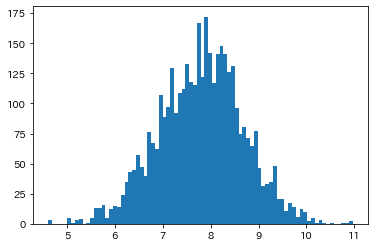

In [21]:
plt.hist(np.array(result1[100:]),bins= 80)

(array([   3.,    0.,    0.,    0.,    0.,    5.,    2.,    1.,    1.,
           3.,    2.,   11.,    6.,    6.,    1.,   10.,    8.,   32.,
          15.,   30.,   26.,   24.,   34.,   54.,   56.,   54.,   67.,
          66.,   68.,   71.,  110.,   92.,   95.,  116.,  152.,  127.,
         173.,  146.,  125.,  157.,  144.,  175.,  162.,   95.,  155.,
         136.,  112.,  116.,  105.,   95.,   99.,   62.,   67.,   66.,
          45.,   50.,   28.,   26.,   42.,   24.,   16.,   11.,   26.,
          16.,   14.,   12.,   12.,   12.,    0.,    4.,    7.,    1.,
           6.,    1.,    3.,    3.,    0.,    1.,    1.,    1.]),
 array([-0.97288817, -0.89850489, -0.82412161, -0.74973833, -0.67535505,
        -0.60097177, -0.52658849, -0.45220521, -0.37782193, -0.30343865,
        -0.22905537, -0.15467209, -0.08028881, -0.00590553,  0.06847775,
         0.14286103,  0.21724431,  0.29162759,  0.36601087,  0.44039415,
         0.51477743,  0.58916072,  0.663544  ,  0.73792728,  0.81231056,
 

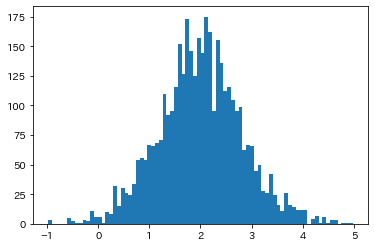

In [22]:
plt.hist(np.array(result2[100:]),bins= 80)

In [23]:
np.array(result1[100:])

array([ 7.02662231,  7.45645394,  7.14062762, ...,  8.6700954 ,
        8.16661002,  8.28284471])

In [24]:
np.array(result2[100:])

array([ 2.68189252,  3.10849609,  2.78974236, ...,  2.1909317 ,
        1.68707293,  1.80291817])

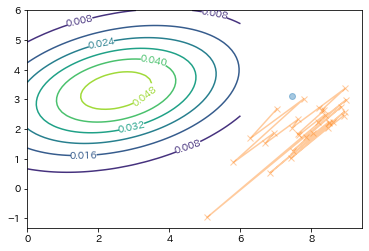

In [26]:
import matplotlib.pyplot as plt
mvn = multivariate_normal(mean,cov)


plt.figure()
ax = plt.gca()

# Create the sample grid
x = np.linspace(0, 6)
y = np.linspace(0, 6)
# Create the meshgrid
X, Y = np.meshgrid(x, y)
Z = np.zeros((X.shape[0], X.shape[1]))
# Get the values
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = mvn.pdf(np.mat([ [X[i,j], Y[i,j]] ]))

# Plot the contours
contourplot = plt.contour(X, Y, Z)
ax.clabel(contourplot, inline=1, fontsize=10)

ax.plot(result1[101],result2[101],'o-',alpha = 0.4)
ax.plot(result1[100::130],result2[100::130],'x-',alpha = 0.4)

# Draw the plot
plt.draw()

In [62]:
x2,y2 = np.random.multivariate_normal(mean,cov,10000).T

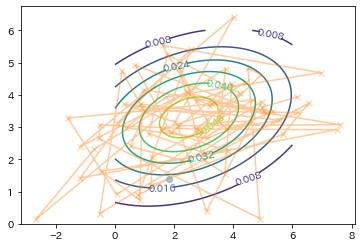

In [63]:
import matplotlib.pyplot as plt
mvn = multivariate_normal(mean,cov)


plt.figure()
ax = plt.gca()

# Create the sample grid
x = np.linspace(0, 6)
y = np.linspace(0, 6)
# Create the meshgrid
X, Y = np.meshgrid(x, y)
Z = np.zeros((X.shape[0], X.shape[1]))
# Get the values
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = mvn.pdf(np.mat([ [X[i,j], Y[i,j]] ]))

# Plot the contours
contourplot = plt.contour(X, Y, Z)
ax.clabel(contourplot, inline=1, fontsize=10)

ax.plot(x2[101],y2[101],'o-',alpha = 0.4)
ax.plot(x2[100::130],y2[100::130],'x-',alpha = 0.4)

# Draw the plot
plt.draw()

In [2]:
import numpy as np

In [12]:
x = 1
y = 1

In [13]:
# 分布関数
np.exp((-1/ (2*(1-0.9**2)) * ( x**2/1.15**2 + 1.15**2 * ( y- 0.5 * (x**2/(1.15**2)) - 0.5* 1.15**2) ** 2 - 2 * 0.9 * x * (y - 0.5* ( x**2)/(1.15**2) - 0.5*1.15**2))))
       
       

0.11287274117367257

In [15]:
# logとマイナス月
# つまり、eからlogを使っておろしてきた。

-0.38/(-1.8* x *(-0.378072 * x**2 + y - 0.66125) + 1.3225 *(-0.378072 * x**2 + y - 0.66125)**2 + 0.756144*x**2)




-0.45840102635518126

In [16]:
# xに関する微分
# D[-0.38/(-1.8* x *(-0.378072 * x**2 + y - 0.66125) + 1.3225 *(-0.378072 * x**2 + y - 0.66125)**2 + 0.756144*x**2), x]

(8.04079 *(x**3 + 2.7* x**2 - 2.645* x *y + 3.749* x - 2.3805* y + 1.5741))/(x**4 + 3.6 *x**3 - 5.29* x**2 *y + 7.49801* x**2 - 9.52199 *x *y + 6.29642* x + 6.99602 *y**2 - 9.25223* y + 3.05902)**2

# yに関する微分



1.6715113959190198